In [5]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from slepy import SLECalculator

In [6]:
axial_p = Path('/Users/jonniebarnsley/Downloads/axial')

In [7]:
with SLECalculator() as calc:
    axial = calc.process_ensemble(axial_p / 'thickness', axial_p / 'Z_base')

Loading ensemble data:
    Run 1/13: ssp5-8.5_run01_thickness_0lev
    Run 2/13: ssp5-8.5_run02_thickness_0lev
    Run 3/13: ssp5-8.5_run03_thickness_0lev
    Run 4/13: ssp5-8.5_run04_thickness_0lev
    Run 5/13: ssp5-8.5_run05_thickness_0lev
    Run 6/13: ssp5-8.5_run06_thickness_0lev
    Run 7/13: ssp5-8.5_run07_thickness_0lev
    Run 8/13: ssp5-8.5_run08_thickness_0lev
    Run 9/13: ssp5-8.5_run09_thickness_0lev
    Run 10/13: ssp5-8.5_run10_thickness_0lev
    Run 11/13: ssp5-8.5_run11_thickness_0lev
    Run 12/13: ssp5-8.5_run12_thickness_0lev
    Run 13/13: ssp5-8.5_run13_thickness_0lev
Calculating sea level equivalent...
📊 Dask dashboard: http://127.0.0.1:8787/status
Completed processing 13 ensemble runs


In [217]:
mid = axial.sel(run=1)
low = axial.sel(run=[3, 5, 6, 8, 10, 12])
high = axial.sel(run=[2, 4, 7, 9, 11, 13])

In [218]:
colors = plt.cm.Set1(np.linspace(0, 1, 8))
colors

array([[0.89411765, 0.10196078, 0.10980392, 1.        ],
       [0.21568627, 0.49411765, 0.72156863, 1.        ],
       [0.30196078, 0.68627451, 0.29019608, 1.        ],
       [0.59607843, 0.30588235, 0.63921569, 1.        ],
       [1.        , 1.        , 0.2       , 1.        ],
       [0.65098039, 0.3372549 , 0.15686275, 1.        ],
       [0.96862745, 0.50588235, 0.74901961, 1.        ],
       [0.6       , 0.6       , 0.6       , 1.        ]])

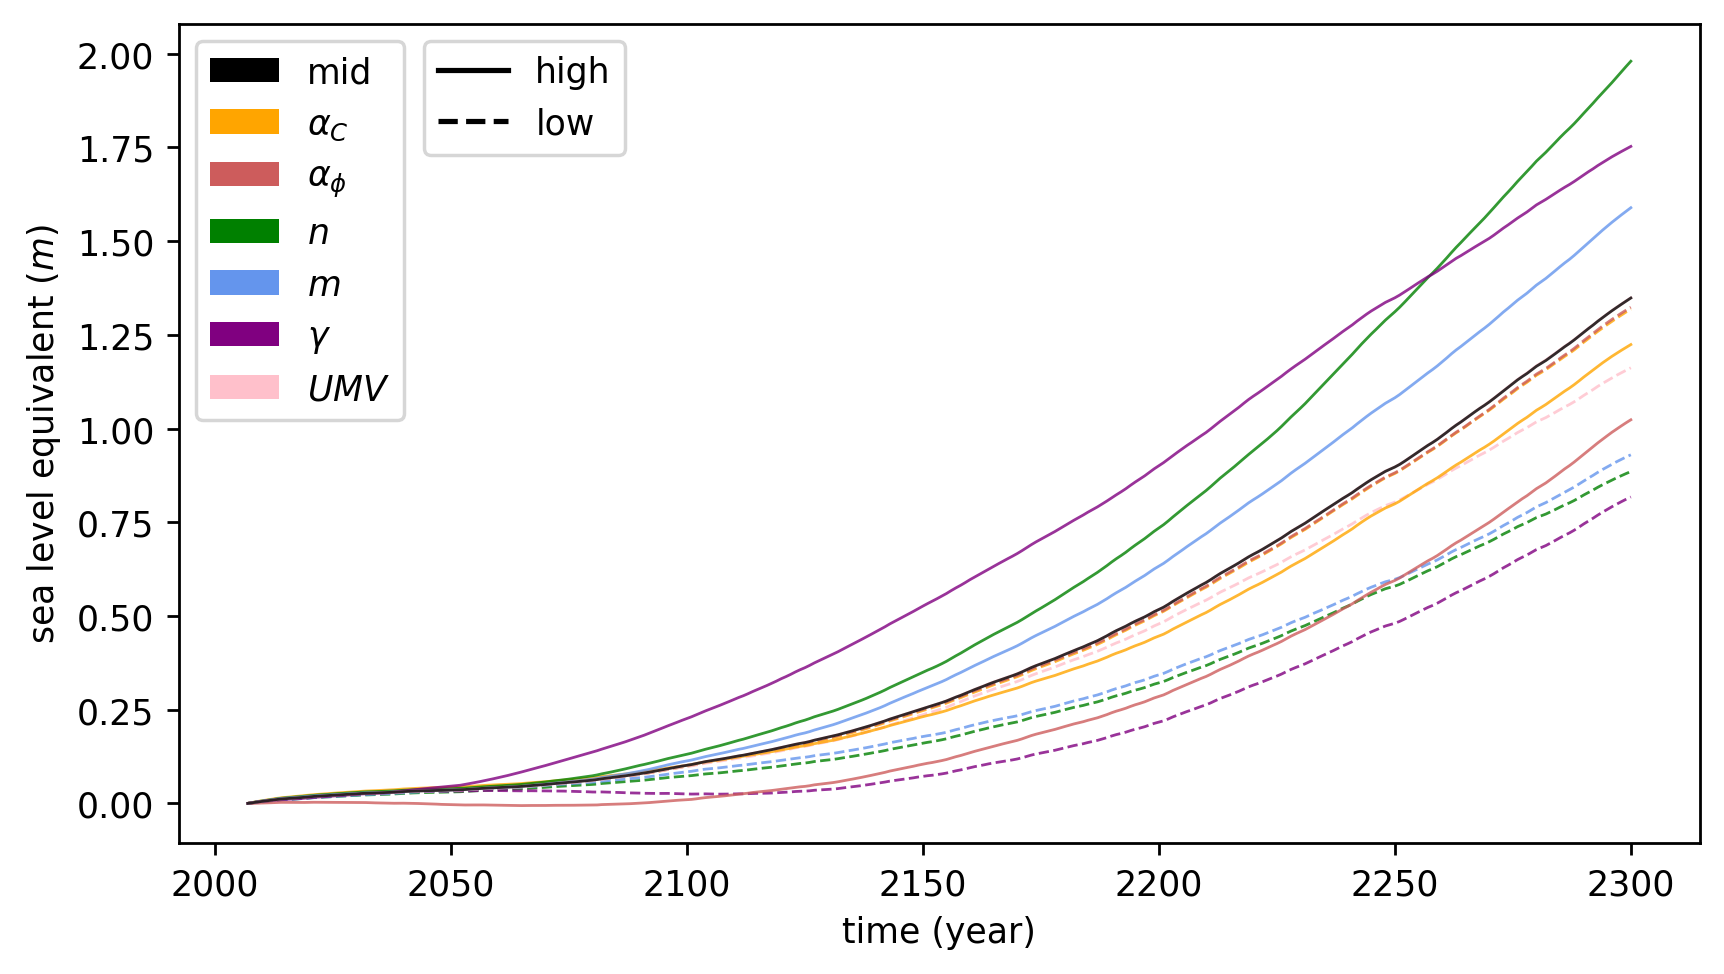

In [280]:
import matplotlib.lines as mlines
from matplotlib.patches import Patch

plt.figure(dpi=250, figsize=(7, 4))
colors = ['black', 'orange', 'indianred', 'green', 'cornflowerblue', 'purple', 'pink']
for i, run in enumerate(low.run, 1):
    plt.plot(low.time, low.sel(run=run), lw=0.8, alpha=0.8, color=colors[i], ls='--')
for i, run in enumerate(high.run, 1):
    plt.plot(high.time, high.sel(run=run), lw=0.8, alpha=0.8, color=colors[i], ls='-')
plt.plot(mid.time, mid, color='black', lw=0.8, label='mid', alpha=0.8)

variables = ['mid', r'$\alpha_C$', r'$\alpha_\phi$', '$n$', '$m$', '$\gamma$', '$UMV$']

#plt.title('SLE time series')
plt.xlabel('time (year)')
plt.ylabel('sea level equivalent ($m$)')

high_line = mlines.Line2D([], [], color='black', linestyle='-', label='high')
low_line = mlines.Line2D([], [], color='black', linestyle='--', label='low')
custom_legend = plt.gca().legend(handles=[high_line, low_line], loc='upper left', bbox_to_anchor=(0.15, 1))

legend_elements = [Patch(facecolor=col, label=lab) for col, lab in zip(colors, variables)]
plt.legend(handles=legend_elements, loc='upper left')

plt.gca().add_artist(custom_legend)
plt.tight_layout()
plt.savefig('/Users/jonniebarnsley/Downloads/axial_2300.svg', dpi=300, format='svg')

In [248]:
sensitivity_2100 = {}
sensitivity_2300 = {}
mid_2100 = mid.sel(time=2100).item()
mid_2300 = mid.sel(time=2300).item()
low = axial.sel(run=[2, 4, 6, 8, 10, 12])
high = axial.sel(run=[3, 5, 7, 9, 11, 13])
for i in range(len(variables)-1):
    var = variables[i+1]

    # 2100
    hi = high.isel(run=i).sel(time=2100).item()
    lo = low.isel(run=i).sel(time=2100).item()
    sensitivity_2100[var] = (lo, mid_2100, hi)

    # 2300
    hi = high.isel(run=i, time=-1).item()
    lo = low.isel(run=i, time=-1).item()
    sensitivity_2300[var] = (lo, mid_2300, hi)

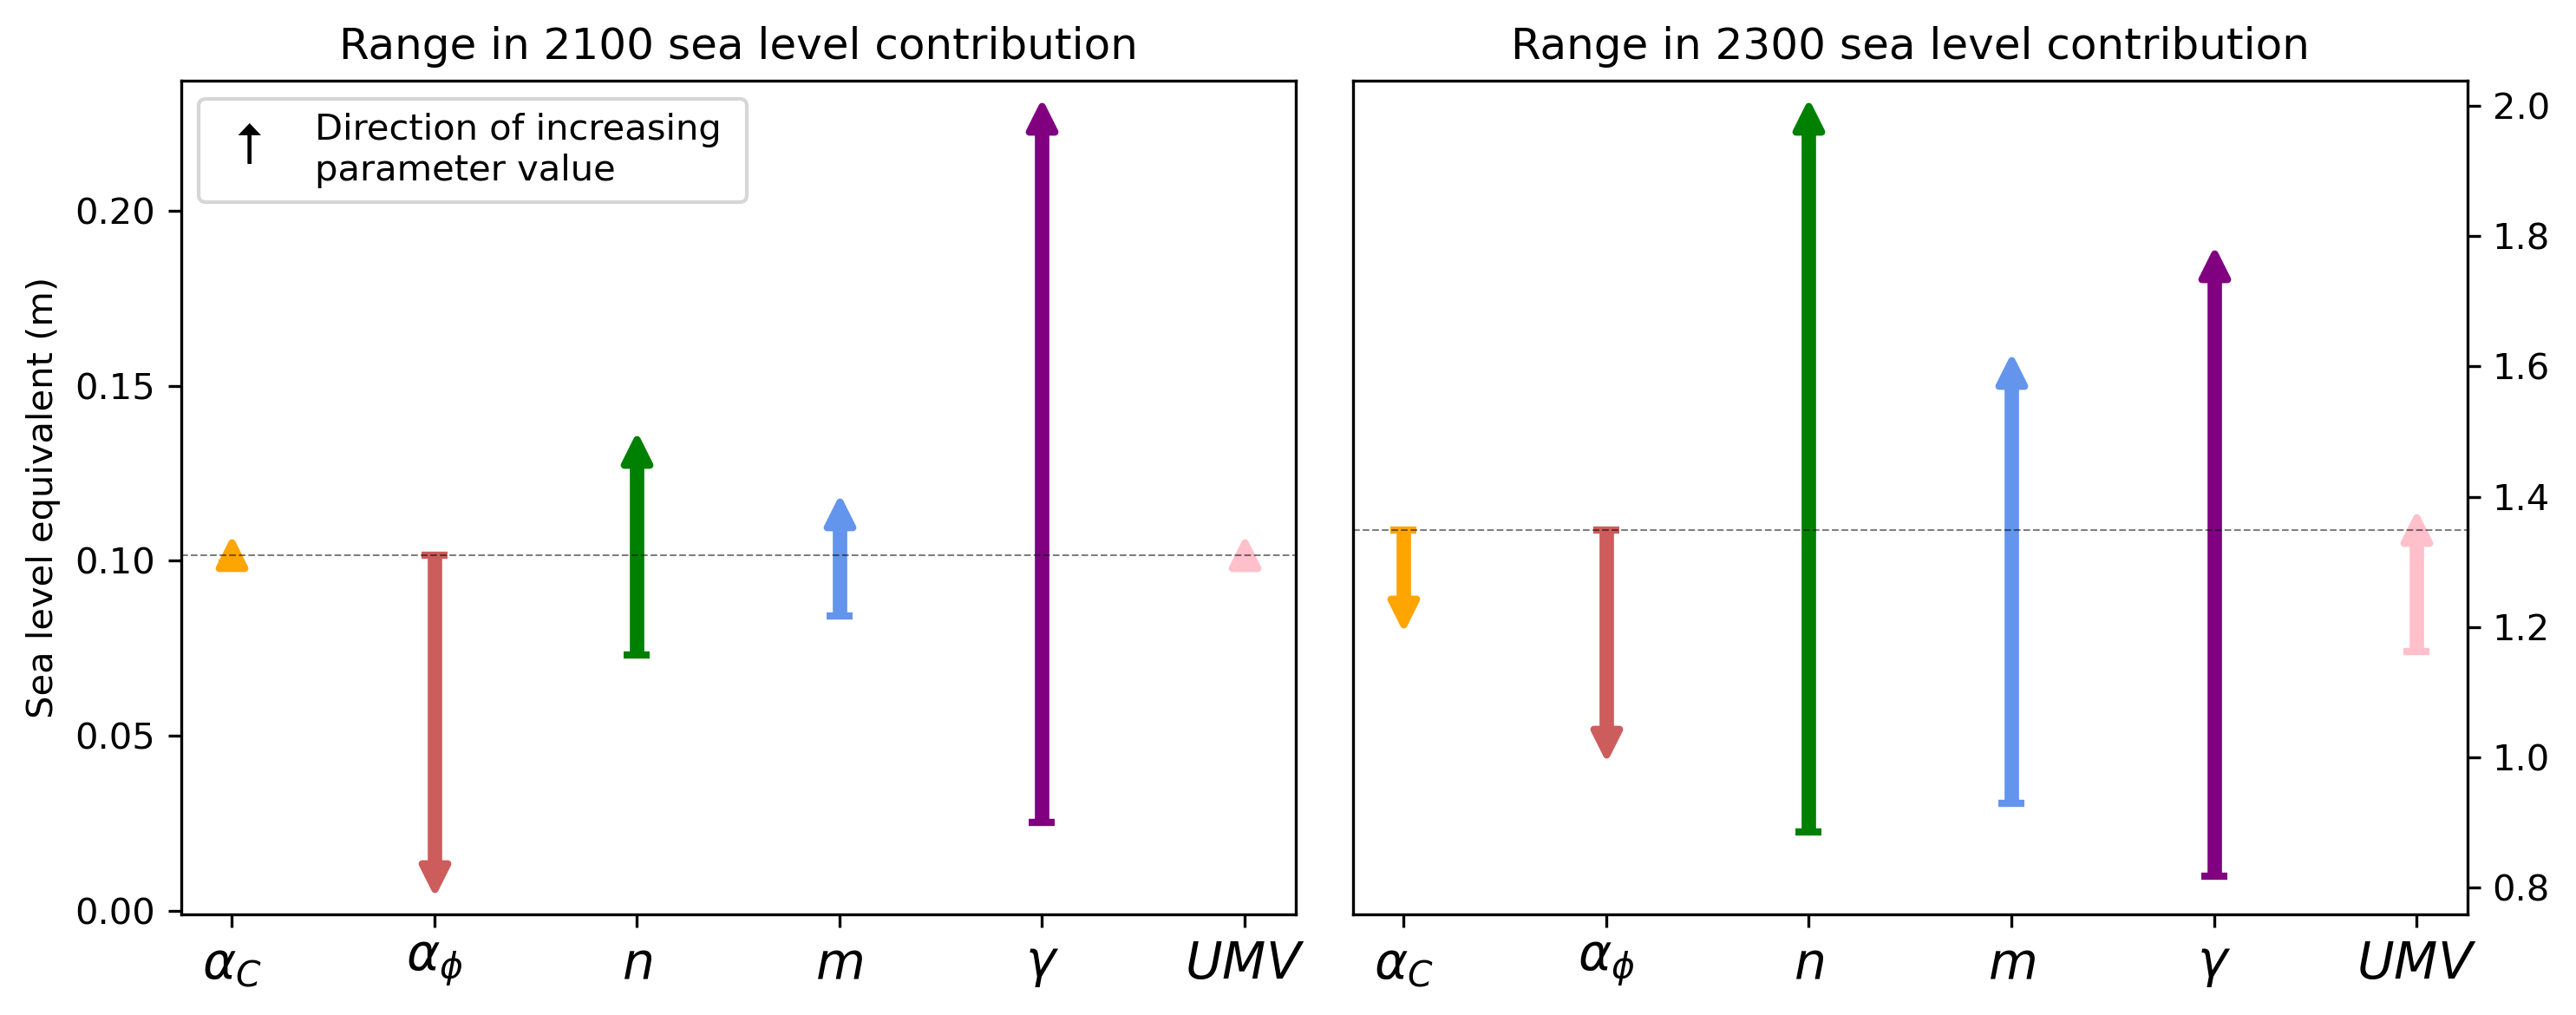

In [282]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 4), ncols=2, dpi=300)
median_2100 = float(mid.sel(time=2100))
median_2300 = float(mid.isel(time=-1))

def plot_bars(data, ax):
    labels, mins, maxs = zip(*[(k, v[0], v[-1]) for k, v in data.items()])
    if data == sensitivity_2100:
        median = median_2100
    else:
        median = median_2300
    x = range(len(labels))

    alpha=1
    for i, (lo, hi, color) in enumerate(zip(mins, maxs, colors[1:])):
        if lo < median and hi < median:
            lo = median
        ax.vlines(i, lo, hi, color=color, lw=4, alpha=alpha)
        ax.scatter(i, lo, color=color, marker='_', s=50, lw=2, alpha=alpha)
        if hi > lo:
            marker = '^'
        elif hi < lo:
            marker = 'v'
        ax.scatter(i, hi, color=color, marker=marker, s=50, lw=2, alpha=alpha)

    ax.set_xticks(x, labels, fontsize=14, fontweight='bold')

    
plot_bars(sensitivity_2100, ax[0])
plot_bars(sensitivity_2300, ax[1])


from matplotlib.patches import FancyArrow
from matplotlib.legend_handler import HandlerPatch

# Custom handler so FancyArrow can appear in legend
class HandlerArrow(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # center arrow inside legend box
        arrow = FancyArrow(width/2, height*0.01, 0, height*1.5,
                           width=0.0, head_width=width*0.2, head_length=height*0.3,
                           length_includes_head=True,
                           color=orig_handle.get_facecolor())
        return [arrow]

# Create a dummy arrow just for legend
arrow_proxy = FancyArrow(0, 0, 0, 1, width=10, head_width=0.2, head_length=0.3, color="black")

# Add legend with custom handler
ax[0].legend([arrow_proxy], ["Direction of increasing \nparameter value"],
             handler_map={FancyArrow: HandlerArrow()},
             fontsize=10, loc="upper left")


ax[0].axhline(median_2100, color='black', lw=0.5, ls='--', alpha=0.5)
ax[1].axhline(median_2300, color='black', lw=0.5, ls='--', alpha=0.5)
#ax[0].text(-0.12, median_2100+0.005, f'{median_2100:.2f} m', fontsize=10, color='black', ha='left')

ax[0].set_ylabel("Sea level equivalent (m)")
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

ax[0].set_title("Range in 2100 sea level contribution")
ax[1].set_title("Range in 2300 sea level contribution")



fig.tight_layout()

plt.savefig('/Users/jonniebarnsley/Downloads/axial_sensitivity.svg', dpi=300, format='svg')

In [15]:
Joughin_labels = {
    1: 'J300',
    2: 'J50'
}

In [22]:
A0_multiplier = get_slc(A0_multiplier_p)

Thickness                                                    Z_base
A0_multiplier_n2E30_thickness_0lev.nc                        A0_multiplier_n2E30_Z_base_0lev.nc
A0_multiplier_n2E50_thickness_0lev.nc                        A0_multiplier_n2E50_Z_base_0lev.nc
A0_multiplier_n4E30_thickness_0lev.nc                        A0_multiplier_n4E30_Z_base_0lev.nc
A0_multiplier_n4E50_thickness_0lev.nc                        A0_multiplier_n4E50_Z_base_0lev.nc


In [23]:
A0_multiplier_labels = {
    1: 'n=2, ref=30 kPa',
    2: 'n=2, ref=50 kPa',
    3: 'n=4, ref=30 kPa',
    4: 'n=4, ref=50 kPa'
}

In [9]:
Creg = get_slc(C_reg_p)

Thickness                                                    Z_base
rerun-aC_high-aC_thickness_0lev.nc                           rerun-aC_high-aC_Z_base_0lev.nc


2025-06-12 15:41:59,999 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:59904 -> tcp://127.0.0.1:59898
Traceback (most recent call last):
  File "/Users/jonniebarnsley/opt/anaconda3/envs/phd/lib/python3.11/site-packages/tornado/iostream.py", line 973, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jonniebarnsley/opt/anaconda3/envs/phd/lib/python3.11/site-packages/tornado/iostream.py", line 1146, in write_to_fd
    return self.socket.send(data)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/jonniebarnsley/opt/anaconda3/envs/phd/lib/python3.11/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^

rerun-aC_high-reg_thickness_0lev.nc                          rerun-aC_high-reg_Z_base_0lev.nc


2025-06-12 15:42:10,788 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:59898 -> tcp://127.0.0.1:59895
Traceback (most recent call last):
  File "/Users/jonniebarnsley/opt/anaconda3/envs/phd/lib/python3.11/site-packages/tornado/iostream.py", line 973, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jonniebarnsley/opt/anaconda3/envs/phd/lib/python3.11/site-packages/tornado/iostream.py", line 1146, in write_to_fd
    return self.socket.send(data)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/jonniebarnsley/opt/anaconda3/envs/phd/lib/python3.11/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^

rerun-aC_run02_thickness_0lev.nc                             rerun-aC_run02_Z_base_0lev.nc
rerun-aC_run03_thickness_0lev.nc                             rerun-aC_run03_Z_base_0lev.nc
rerun-aC_very-high-aC_thickness_0lev.nc                      rerun-aC_very-high-aC_Z_base_0lev.nc


In [12]:
Creg_labels = {
    1: '$a_C$=1e+6',
    2: '$a_C$=1e+4',
    3: '$a_C$=1e-2',
    4: '$a_C$=1e+2',
    5: '$a_C$=1e+8',
}

In [7]:
long_relax = get_slc(long_relax_p)

Thickness                                                    Z_base
long_relax_30yr_relax_thickness_0lev.nc                      long_relax_30yr_relax_Z_base_0lev.nc
long_relax_50yr_relax_thickness_0lev.nc                      long_relax_50yr_relax_Z_base_0lev.nc


(-0.1, 2.0)

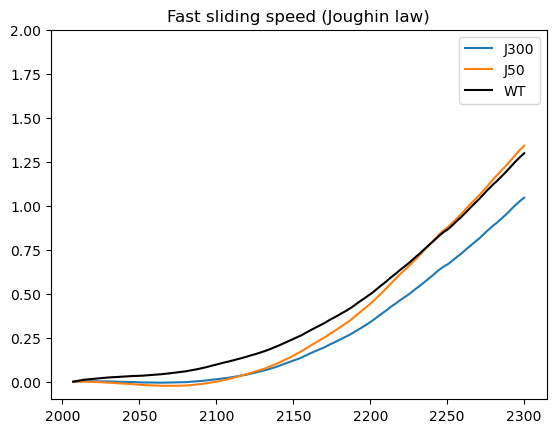

In [71]:
for run in Joughin.run.values:
    plt.plot(Joughin.time, Joughin.sel(run=run), label=f'{Joughin_labels[run]}')

mid = axial.sel(run=3)
plt.plot(mid.time, mid, label='WT', color='black', linestyle='-')

plt.legend()
plt.title('Fast sliding speed (Joughin law)')
plt.ylim(-0.1, 2)

Text(0, 0.5, 'Sea level contribution (m)')

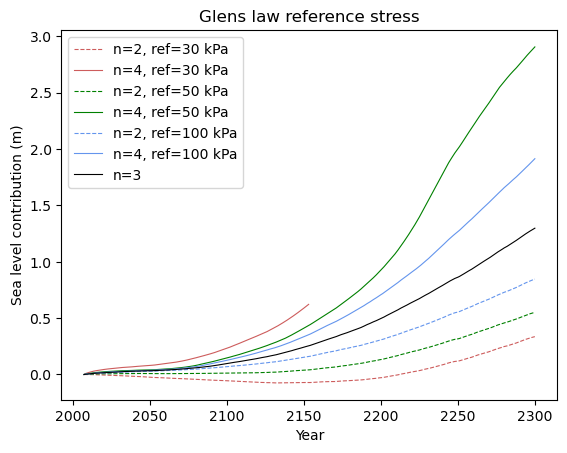

In [25]:
lw=0.8
formatting = {
    1: {'color': 'indianred', 'linestyle': '--'},
    2: {'color': 'green', 'linestyle': '--'},
    3: {'color': 'indianred', 'linestyle': '-'},
    4: {'color': 'green', 'linestyle': '-'}
}

for run in A0_multiplier.run.values:
    plt.plot(A0_multiplier.time, A0_multiplier.sel(run=run), label=f'{A0_multiplier_labels[run]}', \
             color=formatting[run]['color'], linestyle=formatting[run]['linestyle'], lw=lw)
    
n2E100 = axial.sel(run=6)
n4E100 = axial.sel(run=7)
plt.plot(n2E100.time, n2E100, label='n=2, ref=100 kPa', color='cornflowerblue', linestyle='--', lw=lw)
plt.plot(n4E100.time, n4E100, label='n=4, ref=100 kPa', color='cornflowerblue', linestyle='-', lw=lw)

mid = axial.sel(run=3)
plt.plot(mid.time, mid, label='n=3', color='black', linestyle='-', lw=lw)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 2, 1, 3, 4, 5, 6]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.title('Glens law reference stress')

plt.xlabel('Year')
plt.ylabel('Sea level contribution (m)')

Text(0.5, 1.0, 'main axial ensemble')

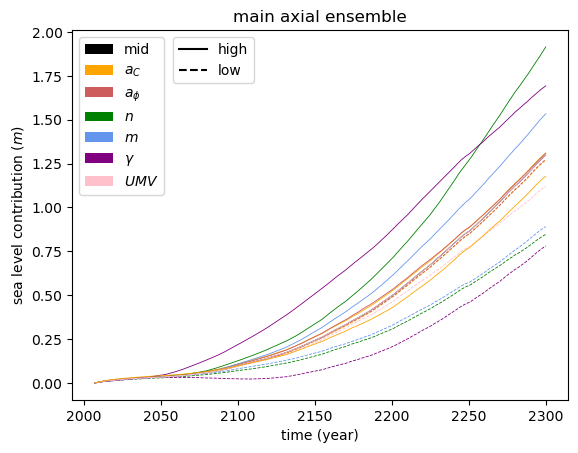

In [93]:
lw=0.6

formatting = {
    1: {'color': 'orange', 'linestyle': '--'},
    2: {'color': 'orange', 'linestyle': '-'},
    3: {'color': 'black', 'linestyle': '-'},
    4: {'color': 'indianred', 'linestyle': '--'},
    5: {'color': 'indianred', 'linestyle': '-'},
    6: {'color': 'green', 'linestyle': '--'},
    7: {'color': 'green', 'linestyle': '-'},
    8: {'color': 'cornflowerblue', 'linestyle': '--'},
    9: {'color': 'cornflowerblue', 'linestyle': '-'},
    10: {'color': 'purple', 'linestyle': '--'},
    11: {'color': 'purple', 'linestyle': '-'},
    12: {'color': 'pink', 'linestyle': '--'},
    13: {'color': 'pink', 'linestyle': '-'}
}

for run in axial.run.values:
    plt.plot(axial.time, axial.sel(run=run), label=f'{run}', \
             color=formatting[run]['color'], linestyle=formatting[run]['linestyle'], linewidth=lw)

high_reg = Creg.sel(run=1)
plt.plot(high_reg.time, high_reg, label='high reg', color='orange', linestyle='-', linewidth=lw)

# very_high_reg = Creg.sel(run=5)
# plt.plot(very_high_reg.time, very_high_reg, label='very high reg', color='orange', linestyle='-', linewidth=lw)

from matplotlib.patches import Patch

# Define your custom colors and labels
colors = ['black', 'orange', 'indianred', 'green', 'cornflowerblue', 'purple', 'pink']
labels = ['mid', '$a_C$', '$a_{\phi}$', '$n$', '$m$', '$\gamma$', '$UMV$']

# Create a list of Patch objects
legend_elements = [Patch(facecolor=col, label=lab) for col, lab in zip(colors, labels)]

# Create a dummy plot (or your actual plot) and add the custom legend



plt.xlabel('time (year)')
plt.ylabel('sea level contribution ($m$)')

plt.savefig('/Users/jonniebarnsley/Downloads/axial_2300(1).png', dpi=300)

plt.title('main axial ensemble')

import matplotlib.lines as mlines
high_line = mlines.Line2D([], [], color='black', linestyle='-', label='high')
low_line = mlines.Line2D([], [], color='black', linestyle='--', label='low')

# Create the legend
custom_legend = plt.gca().legend(handles=[high_line, low_line], loc='upper left', bbox_to_anchor=(0.19, 1))
plt.gca().add_artist(custom_legend)

plt.legend(handles=legend_elements, loc='upper left')

plt.savefig('/Users/jonniebarnsley/Downloads/axial_2300(1).png', dpi=300)

plt.title('main axial ensemble')

In [5]:
thk = xr.open_dataset('/Users/jonniebarnsley/Downloads/run07/thickness/ssp5-8.5_run07_thickness_0lev.nc').thickness
zbase = xr.open_dataset('/Users/jonniebarnsley/Downloads/run07/Z_base/ssp5-8.5_run07_Z_base_0lev.nc').Z_base

from local.lib.GoelzerSLC import GoelzerSLC
run07 = GoelzerSLC(thk, zbase)

Text(0.5, 1.0, 'C-regularisation')

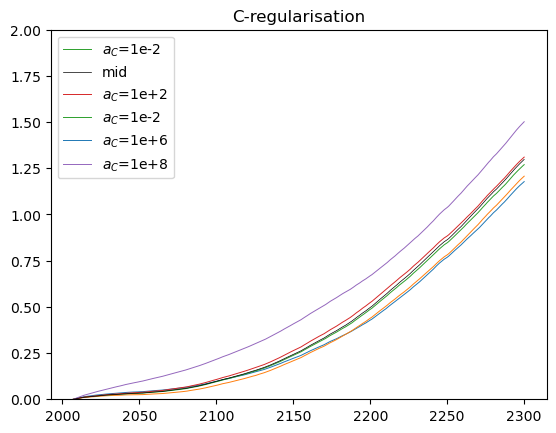

In [13]:
for run in Creg.run.values:
    plt.plot(Creg.time, Creg.sel(run=run), label=f'{Creg_labels[run]}', lw=0.7)

mid = axial.sel(run=3)
plt.plot(mid.time, mid, label='mid', color='black', lw=0.5)
plt.ylim(0, 2)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 5, 3, 2, 0, 4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.title('C-regularisation')

Text(0.5, 1.0, 'Relaxation length')

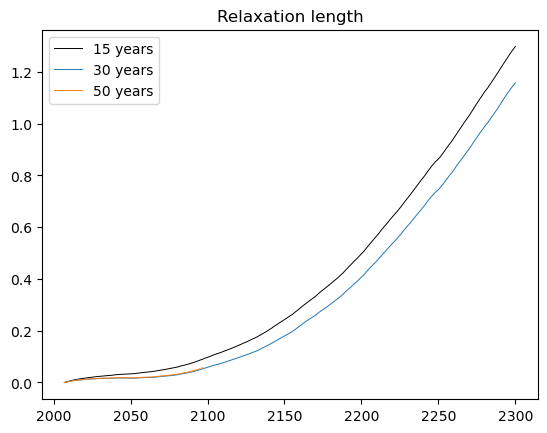

In [20]:
labels = {
    1: '30 years',
    2: '50 years',
}
plt.plot(mid.time, mid, label='15 years', color='black', lw=0.7)

for run in long_relax.run.values:
    plt.plot(long_relax.time, long_relax.sel(run=run), label=labels[run], lw=0.7)

#plt.plot(long_relax.time, long_relax.sel(run=1), label='30yr relaxation', color='black')
plt.legend()
plt.title('Relaxation length')

In [101]:
path = '/Users/jonniebarnsley/Downloads/long_relax/thickness/long_relax_30yr_relax_thickness_0lev.nc'
file = xr.open_dataset(path)
time = file.time

for t in time:
    if (time == t).sum() > 1:
        print(t.values)

2095.0
2095.0


In [106]:
_, index = np.unique(time.values, return_index=True)
new = file.isel(time=index)

In [108]:
print(len(new.time))
print(len(file.time))

295
296
